<a href="https://colab.research.google.com/github/anindabitm/Open-Cities-AI-Challenge-Segmenting-Buildings-for-Disaster-Resilience/blob/master/Open_cities_challenge_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [0]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install segmentation-models
import os
os._exit(0)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import pickle
import os
import glob
import pandas as pd
import cv2
from PIL import Image
from pathlib import Path
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
path='/content/drive/My Drive/open_cities_ai'
ims = glob.glob(path+'/images-256/*.png')
df = pd.DataFrame({
    'img_path':ims,
    'mask_path':[im.replace('images', 'masks').replace('.png', '_mask.png') for im in ims],
    'valid':False
})
# Add some useful columns
#print(df.loc[1]['img_path'])
df['scene_id'] = df['img_path'].apply(lambda x: x.split("_")[3])
df['area'] = df['img_path'].apply(lambda x: x.split("_")[2].split("/")[-1])
# View
print(df.shape)
df.head()

(584, 5)


,img_path,mask_path,valid,scene_id,area
0,/content/drive/My Drive/open_cities_ai/images-...,/content/drive/My Drive/open_cities_ai/masks-2...,False,ca041a,acc
1,/content/drive/My Drive/open_cities_ai/images-...,/content/drive/My Drive/open_cities_ai/masks-2...,False,ca041a,acc
2,/content/drive/My Drive/open_cities_ai/images-...,/content/drive/My Drive/open_cities_ai/masks-2...,False,ca041a,acc
3,/content/drive/My Drive/open_cities_ai/images-...,/content/drive/My Drive/open_cities_ai/masks-2...,False,ca041a,acc
4,/content/drive/My Drive/open_cities_ai/images-...,/content/drive/My Drive/open_cities_ai/masks-2...,False,ca041a,acc


In [0]:
x_train_df = df.loc[df['area']=='acc']['img_path']
y_train_df = df.loc[df['area']=='acc']['mask_path']

In [0]:
s_img=Image.open(y_train_df[100])
np.max(np.array(s_img))

255

# Dataloader and utility functions 

In [0]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x 

In [0]:
# classes for data loading and preprocessing
class Dataset:
    """Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_fn (str): path to image files
        masks_fn (str): path to segmentation masks files
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
        
    def __init__(
            self, 
            images_fn, 
            masks_fn, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_fn = images_fn
        self.masks_fn = masks_fn
        # convert str names to class values on masks
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fn[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = np.asarray(Image.open(self.masks_fn[i]))
        mask=np.expand_dims(mask,axis=-1)        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_fn)

class Test_Dataset():
    """Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_fn (str): path to image files
        masks_fn (str): path to segmentation masks files
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
      
    def __init__(
            self, 
            images_fn, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_fn = images_fn
        self.augmentation=augmentation
        self.preprocessing=preprocessing
           
    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fn[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        dim = (256,256)
        # resize image
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']
        
        return image
        
    def __len__(self):
        return len(self.images_fn)


    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        
        data = []
        for j in range(start, stop):
            
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

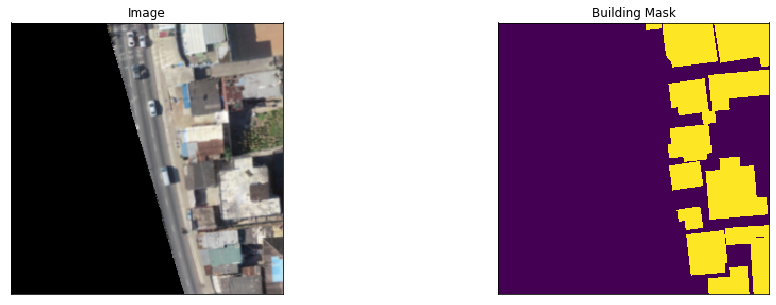

In [0]:
# Lets look at data we have
dataset = Dataset(x_train_df, y_train_df)

image, mask = dataset[5] # get some sample

visualize(
    image=image, 
    building_mask=mask.squeeze(axis=-1)
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [0]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-ijz41c2g
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-ijz41c2g
     |████████████████████████████████| 634kB 4.9MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.4-cp36-none-any.whl size=64266 sha256=3593ca5663480feffa92d765e3db2ddbfe3c15a6f2ca3850c5fe0f1f89e21691
  Stored in directory: /tmp/pip-ephem-wheel-cache-gt1wljwd/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=4a04b8afd060b0612ccc48d878b2bc271f96d4a3c117adebc9ecc676fafa545e
  Stored in directory: /tmp/pip-ephem-wheel-cache-gt1wljwd/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: album

In [0]:
import albumentations as A

In [0]:
import keras

In [0]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        A.RandomCrop(height=256, width=256, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(256, 256),
         A.Lambda(mask=round_clip_0_1)
       
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

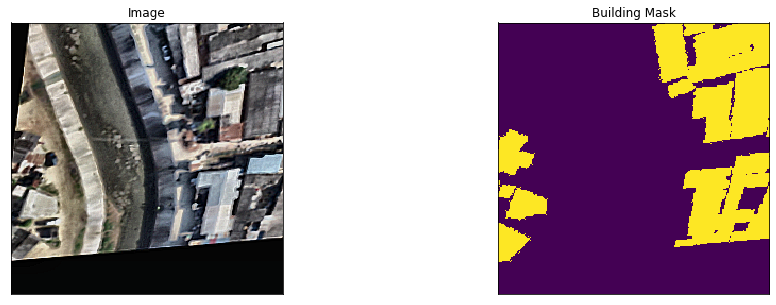

In [0]:
# Lets look at augmented data we have
dataset = Dataset(x_train_df, y_train_df, augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    building_mask=mask.squeeze(axis=-1)
)

# Segmentation model training

In [0]:
#!pip install segmentation-models
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [0]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8

LR = 0.0001
EPOCHS = 10

preprocess_input = sm.get_preprocessing(BACKBONE)

In [0]:
# define network parameters
n_classes = 1  # case for binary and multiclass segmentation
activation = 'sigmoid'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
44113920/44107200 [==============================] - 1s 0us/step




In [0]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [0]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [iou_coef,dice_coef]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [0]:
x_valid_df = df.loc[df['area']!='acc']['img_path'].reset_index()['img_path']
y_valid_df = df.loc[df['area']!='acc']['mask_path'].reset_index()['mask_path']

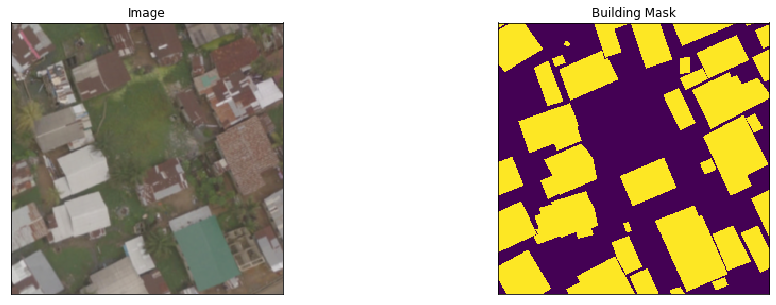

In [0]:
valid_dataset = Dataset(x_valid_df, y_valid_df, augmentation=get_validation_augmentation())
image, mask = valid_dataset[12] # get some sample
visualize(
    image=image, 
    building_mask=mask.squeeze(axis=-1)
)

In [0]:
# Dataset for train images
train_dataset = Dataset(
    x_train_df, 
    y_train_df, 
    
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_df, 
    y_valid_df, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
    )

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [0]:
len(valid_dataloader)

17

In [0]:
# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256,n_classes)

assert valid_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert valid_dataloader[0][1].shape == (BATCH_SIZE, 256, 256,n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/My Drive/open_cities_ai/best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [0]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader), 
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
55/55 [==============================] - 972s 18s/step - loss: 0.7400 - iou_coef: 0.2390 - dice_coef: 0.3604 - val_loss: 0.5917 - val_iou_coef: 0.3528 - val_dice_coef: 0.4932
Epoch 2/10
55/55 [==============================] - 933s 17s/step - loss: 0.5842 - iou_coef: 0.2959 - dice_coef: 0.4256 - val_loss: 0.4912 - val_iou_coef: 0.3952 - val_dice_coef: 0.5373
Epoch 3/10
55/55 [==============================] - 918s 17s/step - loss: 0.5211 - iou_coef: 0.3309 - dice_coef: 0.4635 - val_loss: 0.4701 - val_iou_coef: 0.4156 - val_dice_coef: 0.5572
Epoch 4/10
55/55 [==============================] - 913s 17s/step - loss: 0.4736 - iou_coef: 0.3573 - dice_coef: 0.4896 - val_loss: 0.4788 - val_iou_coef: 0.4379 - val_dice_coef: 0.5782
Epoch 5/10
55/55 [==============================] - 913s 17s/step - loss: 0.4404 - iou_coef: 0.3809 - dice_coef: 0.5134 - val_loss: 0.4209 - val_iou_coef: 0.456

In [0]:
model.save('/content/drive/My Drive/open_cities_ai/my_model.h5')

In [0]:
# load best weights
model.load_weights('/content/drive/My Drive/open_cities_ai/my_model.h5') 

NameError: ignored

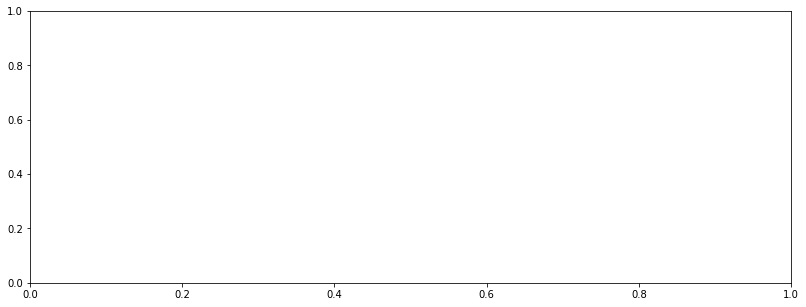

In [0]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [0]:
x_test_df=pd.read_csv('/content/drive/My Drive/open_cities_ai/test/test.csv')
x_test_df.head()

,Unnamed: 0,fn,id
0,0,/content/drive/My Drive/open_cities_ai/test/e9...,e93a2d
1,1,/content/drive/My Drive/open_cities_ai/test/e9...,e959dc
2,2,/content/drive/My Drive/open_cities_ai/test/e9...,e91b9c
3,3,/content/drive/My Drive/open_cities_ai/test/e9...,e94422
4,4,/content/drive/My Drive/open_cities_ai/test/e9...,e98330


In [0]:
type(x_test_df['fn'])
x_test_df.shape

(11481, 3)

# Model Prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


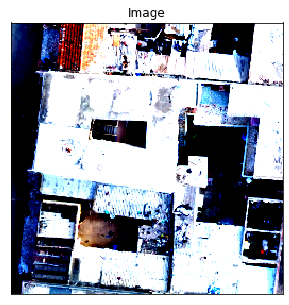

In [0]:
test_dataset = Test_Dataset(x_test_df['fn'],augmentation=get_validation_augmentation(),preprocessing=get_preprocessing(preprocess_input))
image = test_dataset[105] # get some sample
visualize(
    image=image
    )

In [0]:
test_dataset = Test_Dataset(x_test_df['fn'],augmentation=get_validation_augmentation(),preprocessing=get_preprocessing(preprocess_input),)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

# Visualization of results on test dataset

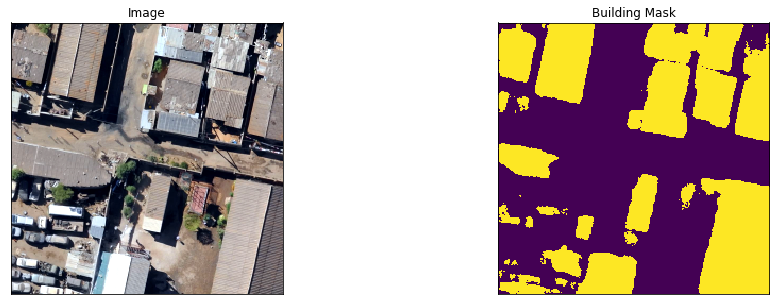

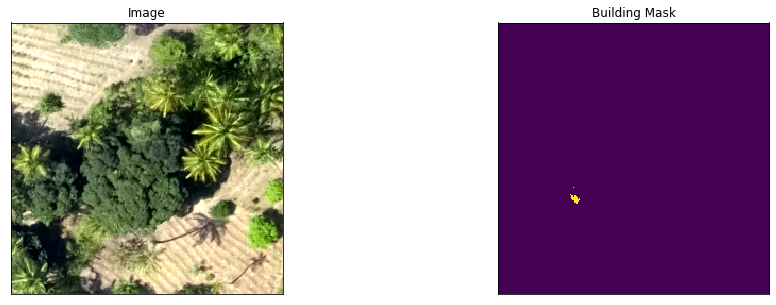

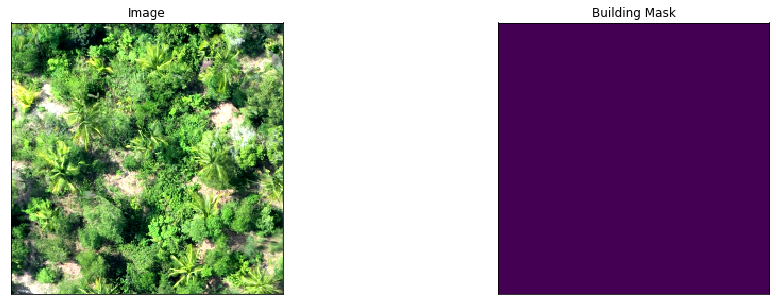

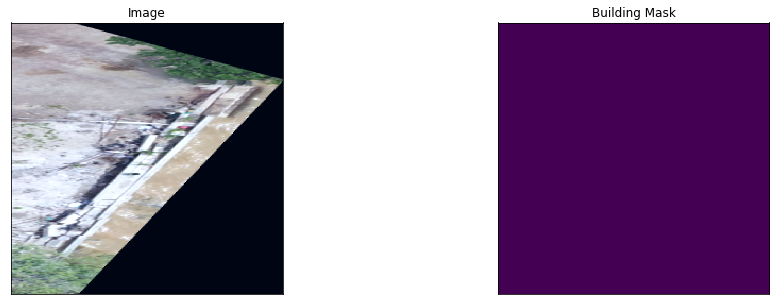

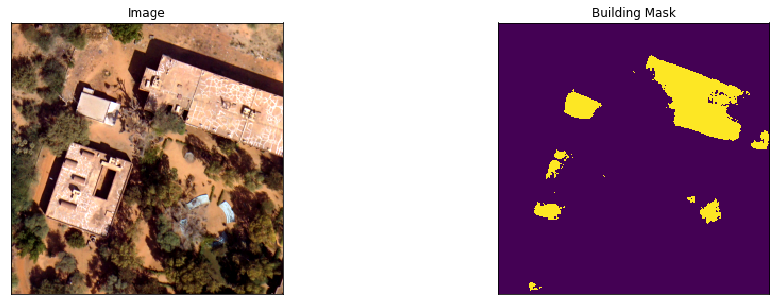

In [0]:
n = 5

for i in np.random.choice(np.arange(len(test_dataloader)), size=n):
    
    image = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    mask =  model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        building_mask=mask.squeeze(axis=0).squeeze(axis=-1)
        
    )

In [0]:
!rm -rf '/content/drive/My Drive/open_cities_ai/submission'
!mkdir '/content/drive/My Drive/open_cities_ai/submission'

In [0]:
from tqdm import tqdm

for i in tqdm(range(len(x_test_df))):
  im_id = x_test_df['id'].values[i]
  mask = model.predict(np.expand_dims(test_dataset[i],axis=0)).round()
  pred_arr = mask.squeeze(axis=0).squeeze(axis=-1)
  pred_im = Image.fromarray(pred_arr.astype(np.uint8))
  scaled_im = pred_im.resize((1024, 1024), Image.NEAREST)
  scaled_im.save('/content/drive/My Drive/open_cities_ai/submission/'+str(im_id)+'.TIF', compression='tiff_deflate')
  

100%|██████████| 11481/11481 [3:27:53<00:00,  1.05s/it]


In [0]:
import os
for i in range(len(x_test_df)):
  im_id = x_test_df['id'].values[i]
  if not os.path.isfile('/content/drive/My Drive/open_cities_ai/submission/'+str(im_id)+'.TIF'):
    print(im_id)

In [0]:
!cd '/content/drive/My Drive/open_cities_ai/submission'; zip -q -r submission.zip *.TIF # Add to archive